In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 40
CHANNELS = 3
EPOCHS = 5
SHUFFLE = 10000

In [3]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    shuffle = True,
    batch_size = BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = df.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [5]:
len(df)

62

In [6]:
for image_batch, label_batch in df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(40, 256, 256, 3)
[0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1
 1 1 0]


In [7]:
print(image_batch[0].numpy()) # it is showing us that the dataset of the images  have code in the form of Numpy Arrays.

[[[164. 155. 158.]
  [161. 152. 155.]
  [165. 156. 159.]
  ...
  [124. 115. 118.]
  [118. 109. 112.]
  [162. 153. 156.]]

 [[145. 136. 139.]
  [143. 134. 137.]
  [167. 158. 161.]
  ...
  [142. 133. 136.]
  [136. 127. 130.]
  [138. 129. 132.]]

 [[178. 169. 172.]
  [163. 154. 157.]
  [176. 167. 170.]
  ...
  [131. 122. 125.]
  [138. 129. 132.]
  [124. 115. 118.]]

 ...

 [[170. 161. 164.]
  [202. 193. 196.]
  [173. 164. 167.]
  ...
  [139. 128. 126.]
  [135. 124. 122.]
  [124. 113. 111.]]

 [[154. 145. 148.]
  [161. 152. 155.]
  [131. 122. 125.]
  ...
  [156. 145. 143.]
  [154. 143. 141.]
  [117. 106. 104.]]

 [[172. 163. 166.]
  [161. 152. 155.]
  [181. 172. 175.]
  ...
  [173. 162. 160.]
  [122. 111. 109.]
  [137. 126. 124.]]]


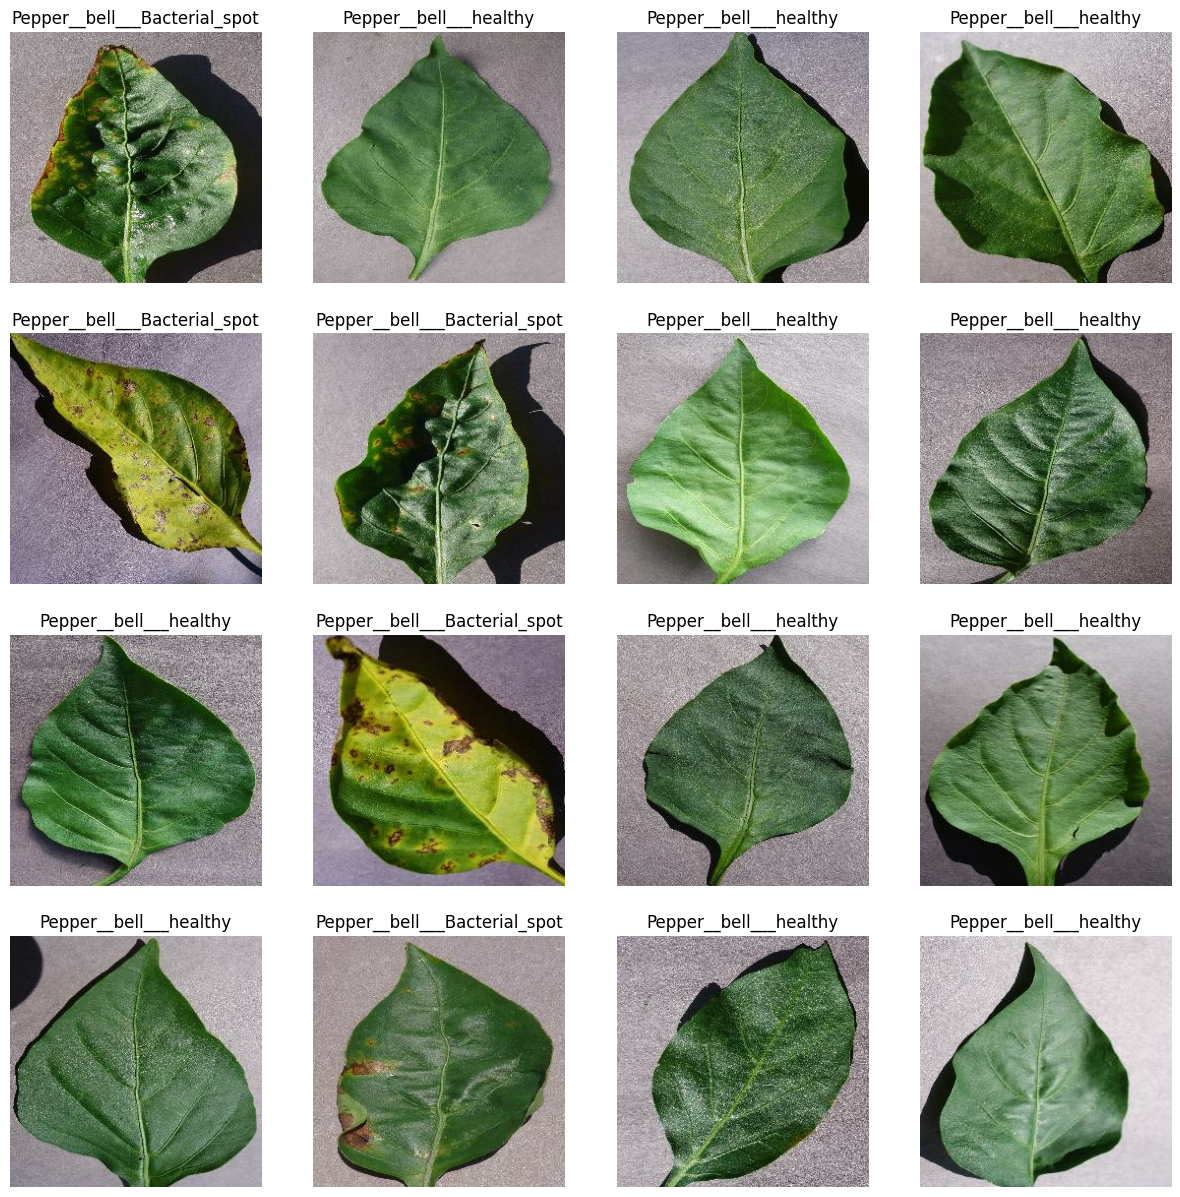

In [8]:
plt.figure(figsize=(15,15))
for i in range(16):
    ax = plt.subplot(4,4, i+1),
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [9]:
def get_dataset_partitions_tf(df, train_split = 0.8, val_split=0.1, test_split= 0.1, shuffle_size = 10000 ):
    shuffle = SHUFFLE
    df_size = len(df)
    if shuffle:
       df =  df.shuffle(shuffle_size,seed=12)
        
    train_size = int(train_split * df_size)
    val_size = int(val_split * df_size)

    train_df = df.take(train_size)
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)
    return train_df, val_df, test_df


In [10]:
train_df, val_df, test_df = get_dataset_partitions_tf(df)

In [11]:
len(train_df)

49

In [12]:
len(val_df)

6

In [13]:
len(test_df)

7

In [14]:
# make dataset partition more responsive as fast
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Model Training

In [15]:
# resizing and rescaling of dataset to equalize them at all
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255),
])

In [16]:
# doing data augmentation to enhance the precision and prediction of any image in any condition
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3  # n_classes represents the neurons
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64 ,activation='relu'),
    layers.Dense(n_classes ,activation='softmax'),
])
model.build(input_shape=input_shape)

c:\Users\akr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (40, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (40, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (40, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (40, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (40, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (40, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (40, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (40, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (40, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (40, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (40, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (40, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (40, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (40, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (40, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (40, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (40, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile (
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [20]:
history = model.fit(
    train_df,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_df
)

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.5896 - loss: 0.7226 - val_accuracy: 0.7660 - val_loss: 0.5423
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8410 - loss: 0.3933 - val_accuracy: 0.9064 - val_loss: 0.2417
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9430 - loss: 0.1633 - val_accuracy: 0.9660 - val_loss: 0.1296
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.9573 - loss: 0.1307 - val_accuracy: 0.9660 - val_loss: 0.0833
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9737 - loss: 0.0807 - val_accuracy: 0.9872 - val_loss: 0.0490


In [21]:
scores = model.evaluate(test_df)

7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 421ms/step - accuracy: 0.9886 - loss: 0.0489


### Checking Model Accuracy and its history of being accurate

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

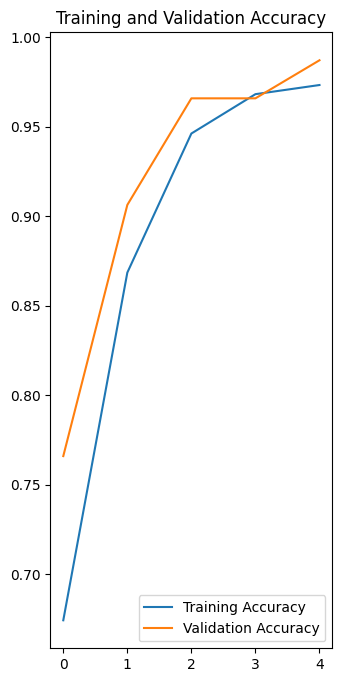

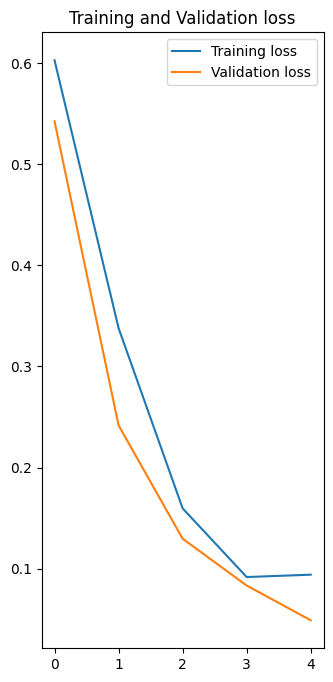

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss , label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

## Making and Checking Predictions

first image to predict
first image actual label:  Pepper__bell___healthy


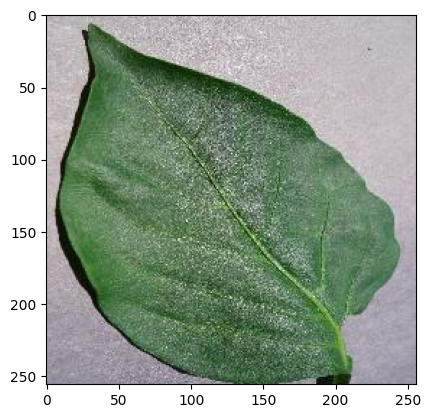

In [24]:
for image_batch, label_batch in test_df.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print('first image actual label: ', class_names[first_label])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array = tf.expand_dims(img_array, 0) 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.argmax(predictions[0])), 2)
    return predicted_class, confidence

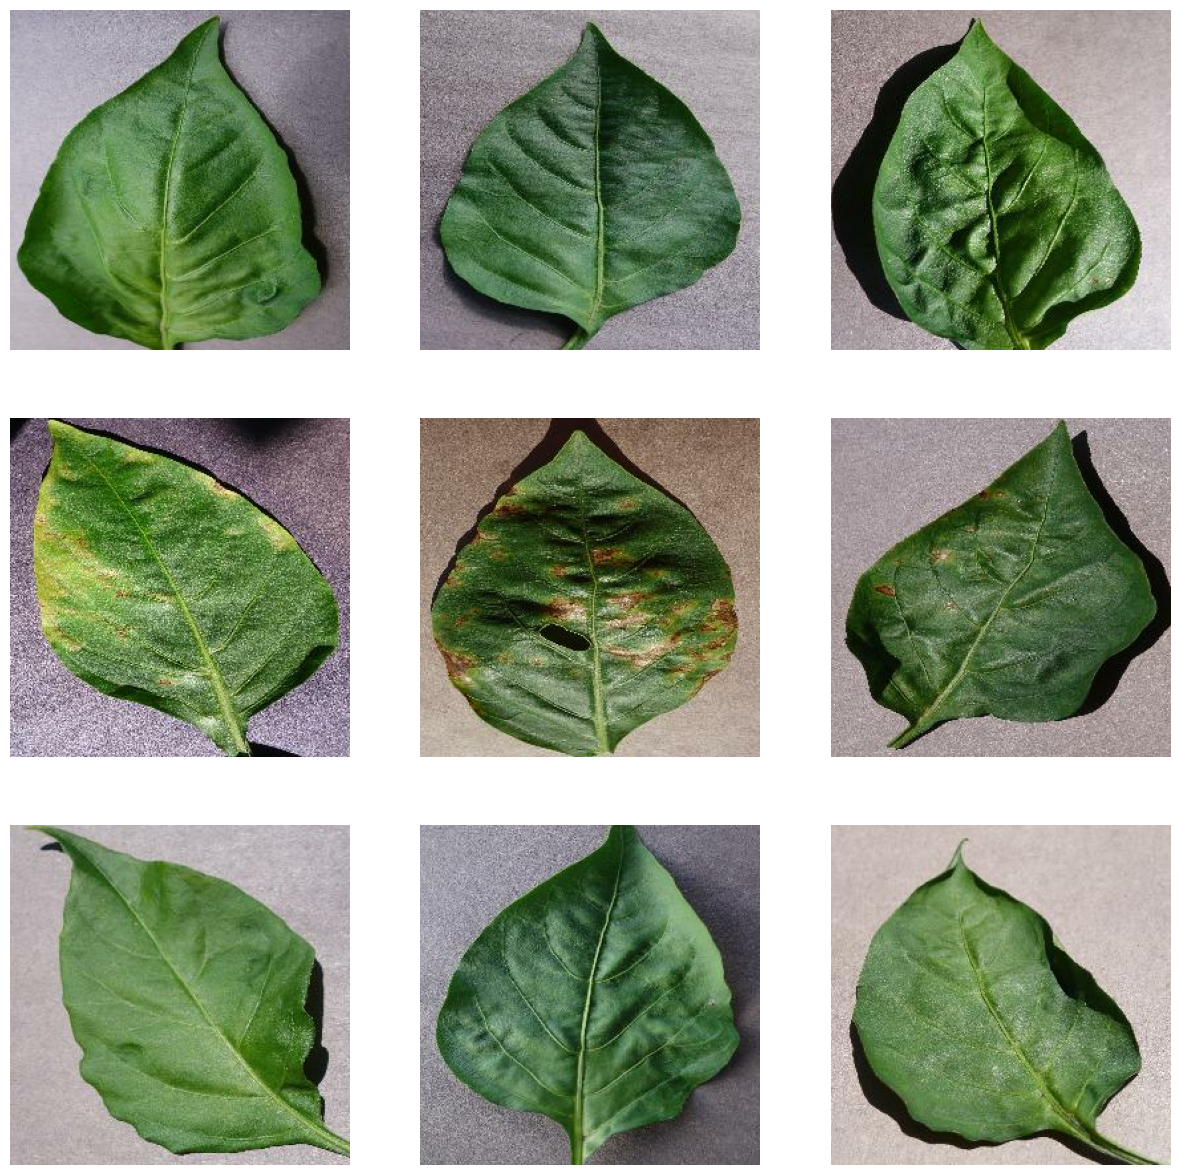

In [26]:
plt.figure(figsize=(15, 15))
for images,labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i +1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        actual_class = class_names[labels[i]]
        
        plt.axis('off')

In [27]:
model_name = "Pepper Bell Classification Model"
model.save(f"../Deep_Learning_Models/{model_name}.keras")